# ATEPP Audio

In [1]:
import pandas as pd
import numpy as np
import glob
import librosa
import os
from tqdm import tqdm
import IPython.display as ipd
import torch
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
ATEPP_metadata = pd.read_csv('./metadata/ATEPP-audio-full-metadata.csv')
ATEPP_metadata

artist  artist_id  \
0      Vladimir Ashkenazy          6   
1      Vladimir Ashkenazy          6   
2      Vladimir Ashkenazy          6   
3       Vladimir Horowitz          2   
4      Vladimir Ashkenazy          6   
...                   ...        ...   
11757    Walter Gieseking          8   
11758       Claudio Arrau         11   
11759       András Schiff          4   
11760     Friedrich Gulda         24   
11761       András Schiff          4   

                                                   track  \
0        10 Mazurkas, Op.3 (1889): No.10 in E Flat Minor   
1      10 Mazurkas, Op.3 (1889): No.6 in C Sharp Mino...   
2      10 Mazurkas, Op.3 (1889): No.7 in E Minor (Con...   
3               12 Études, Op. 8: No. 10 in D-Flat Major   
4               12 Etudes, Op. 8: No. 10 in D-Flat Major   
...                                                  ...   
11757                           Rondo in D Major, K. 485   
11758                           Rondo in D Major, K. 485   
11759  Ten Variations in G, K.455 on "Unser dummer Pö...   
11760  10 Variations in G, K.455 on "Unser dummer Pöb...   
11761  Twelve Variations in C on "Ah, vous dirai-je M...   

                      composer  \
0           Alexander Scriabin   
1           Alexander Scriabin   
2           Alexander Scriabin   
3           Alexander Scriabin   
4           Alexander Scriabin   
...                        ...   
11757  Wolfgang Amadeus Mozart   
11758  Wolfgang Amadeus Mozart   
11759  Wolfgang Amadeus Mozart   
11760  Wolfgang Amadeus Mozart   
11761  Wolfgang Amadeus Mozart   

                                              piece_path  \
0      .\audio\Alexander_Scriabin\10_Mazurkas,_Op.3_(...   
1      .\audio\Alexander_Scriabin\10_Mazurkas,_Op.3_(...   
2      .\audio\Alexander_Scriabin\10_Mazurkas,_Op.3_(...   
3      .\audio\Alexander_Scriabin\12_Etudes,_Op._8\No...   
4      .\audio\Alexander_Scriabin\12_Etudes,_Op._8\No...   
...                                                  ...   
11757  .\audio\Wolfgang_Amadeus_Mozart\Rondo_in_D_Maj...   
11758  .\audio\Wolfgang_Amadeus_Mozart\Rondo_in_D_Maj...   
11759  .\audio\Wolfgang_Amadeus_Mozart\Ten_Variations...   
11760  .\audio\Wolfgang_Amadeus_Mozart\Ten_Variations...   
11761  .\audio\Wolfgang_Amadeus_Mozart\Twelve_Variati...   

                                      youtube_link  \
0      https://www.youtube.com/watch?v=qdUAJB8nCN4   
1      https://www.youtube.com/watch?v=2Vz36Bjn4zI   
2      https://www.youtube.com/watch?v=0fomXySkj2I   
3      https://www.youtube.com/watch?v=aGKaIpNxKrk   
4      https://www.youtube.com/watch?v=SsB5go203EM   
...                                            ...   
11757  https://www.youtube.com/watch?v=LsZDmMI0fQQ   
11758  https://www.youtube.com/watch?v=zQzuJY-KRRE   
11759  https://www.youtube.com/watch?v=du9IK5m8UeY   
11760  https://www.youtube.com/watch?v=Uyg3O1KZFWU   
11761  https://www.youtube.com/watch?v=7FU189_fW7Q   

                                                   album  \
0                               Scriabin: Vers la Flamme   
1                               Scriabin: Vers la Flamme   
2                               Scriabin: Vers la Flamme   
3      Vladimir Horowitz: The Complete Masterworks Re...   
4                               Scriabin: Vers la Flamme   
...                                                  ...   
11757                  Mozart: Complete Solo Piano Works   
11758                   Piano Recitals 1954, 1960 & 1963   
11759  Mozart: Ah! Vous dirai-je maman Variations; Un...   
11760                                 Gulda plays Mozart   
11761  Mozart: Ah! Vous dirai-je maman Variations; Un...   

      album_date(yyyy-mm-dd)  
0                 2015-04-06  
1                 2015-04-06  
2                 2015-04-06  
3                       1962  
4                 2015-04-06  
...                      ...  
11757             2018-06-15  
11758             2018-01-12  
11759             1988-01-01  
11760  

In [3]:
# load example local audio file 
n = 4
print(ATEPP_metadata['piece_path'][n])
display(ipd.Audio(ATEPP_metadata['piece_path'][n]))

.\audio\Alexander_Scriabin\12_Etudes,_Op._8\No._10_in_D-Flat_Major\2.mp3


In [7]:
artists = ATEPP_metadata['artist'].to_numpy()
pianists, counts = np.unique(artists, return_counts=True)
composers = ATEPP_metadata['composer'].to_numpy()
print(len(ATEPP_metadata), 'performances in full dataset')
print(len(np.unique(composers)), 'composers in full dataset')
print(len(pianists), 'pianists in full dataset') 

11762 performances in full dataset
25 composers in full dataset
49 pianists in full dataset


### Dataset selection for traditional ML tasks

In [3]:
# performers that appear >= 15 times 

df_filtered = ATEPP_metadata.groupby('artist_id').filter(lambda x: len(x) >= 15)

# checking unbalancedness of df_filtered dataset 

artist_ids = df_filtered['artist'].to_numpy() 
pianist_ids, counts = np.unique(artist_ids, return_counts=True)
for pianist, count in zip(pianist_ids, counts):
    print(f"{pianist}: {count}")

print('')
print(len(df_filtered), 'performances')
print(len(df_filtered['artist_id'].unique()), 'pianists in filtered dataset')

# note: there's no artist_id = 37
# least number = 22 performances
# most number = 1584 performances

Alexandre Tharaud: 45
Alfred Brendel: 750
Alfred Cortot: 124
Alice Sara Ott: 58
Alicia de Larrocha: 116
András Schiff: 600
Anne Queffélec: 29
Artur Schnabel: 242
Arturo Benedetti Michelangeli: 101
Bertrand Chamayou: 22
Claudio Arrau: 835
Daniel Barenboim: 606
Dinu Lipatti: 69
Edwin Fischer: 83
Emanuel Ax: 57
Emil Gilels: 324
Evgeny Kissin: 98
Friedrich Gulda: 460
Glenn Gould: 346
Grigory Sokolov: 107
Hélène Grimaud: 59
Ivo Pogorelich: 42
Krystian Zimerman: 31
Lang Lang: 115
Lazar Berman: 52
Leif Ove Andsnes: 40
Martha Argerich: 244
Maurizio Pollini: 262
Mikhail Pletnev: 93
Mitsuko Uchida: 214
Murray Perahia: 291
Myra Hess: 40
Nikolai Lugansky: 125
Pierre-Laurent Aimard: 32
Radu Lupu: 104
Robert Casadesus: 164
Samson François: 237
Sviatoslav Richter: 1584
Valentina Lisitsa: 61
Van Cliburn: 43
Vladimir Ashkenazy: 1192
Vladimir Horowitz: 581
Walter Gieseking: 362
Wilhelm Kempff: 612
Zoltán Kocsis: 93

11745 performances
45 pianists in filtered dataset


In [4]:
### DATASET SELECTION TO ASSESS LEARNED STYLE VS ENVIRONMENT ###
# using seperate years in test set to investigate if models learn style vs environment

df_filtered2 = df_filtered.copy()

# performers = df_filtered2.groupby('artist')['album'].nunique()
# min(performers), max(performers) # 4, 150

# using album year to reflect different environments
df_filtered2['album_date(yyyy-mm-dd)'] = pd.to_datetime(df_filtered2['album_date(yyyy-mm-dd)'])
df_filtered2['album_year'] = df_filtered2['album_date(yyyy-mm-dd)'].dt.year
performers = df_filtered2.groupby('artist')['album_year'].nunique()
#min(performers), max(performers) # 3, 46

# split into train and test sets
def custom_train_test_split(df, test_size=0.16, random_state=42):
    np.random.seed(random_state)
    train_idx = []
    test_idx = []

    for artist in df['artist_id'].unique():
        artist_df = df[df['artist_id'] == artist]
        album_years = artist_df['album_year'].unique()
        np.random.shuffle(album_years) # ensures years are not selected in order

        # calculate the number of unique years for the test set (proportional to the test size)
        n_test_years = int(np.ceil(len(album_years) * test_size))
        # split the album years into train and test sets
        test_years = album_years[:n_test_years]
        train_years = album_years[n_test_years:]

        # get the indices of the rows that belong to the train and test sets based on the album years
        train_idx.extend(artist_df[artist_df['album_year'].isin(train_years)].index)
        test_idx.extend(artist_df[artist_df['album_year'].isin(test_years)].index)

    return df.loc[train_idx], df.loc[test_idx]

train_df, test_df = custom_train_test_split(df_filtered2, test_size=0.16, random_state=42)

# ~80:20 train:test split
#len(train_df), len(test_df) #(9474, 2271) # test size is larger than 0.16 because np.ceil is used 

# e.g. for artist_id=1 (Emil Gilels) 
print('train set: ', train_df[train_df['artist_id'] == 1]['album_year'].unique())
print('test set: ', test_df[test_df['artist_id'] == 1]['album_year'].unique())

train set:  [2017 2016 2008 1965 2012 2000 1974 2021 1960 1961 2020 2011 2006 2010
 1979 1949 1995 1955 2005 1986 1981 1997 1996 2001 2007 2014]
test set:  [2018 1999 2013 2004 1998]


### Dataset selection for NN

In [4]:
# just using all >= 15 times is too many, so using a more balanced dataset for NN:
# selecting performers that appear >=115 times
# sampling 40% of those with >=600 performances
# reduces dataset size and makes it more balanced

df_115_to_600 = ATEPP_metadata.groupby('artist_id').filter(lambda x: len(x) >= 115 and len(x) < 600)
df_600_or_more = ATEPP_metadata.groupby('artist_id').filter(lambda x: len(x) >= 600)
df_sample_of_600_or_more = df_600_or_more.sample(frac=0.4, random_state=1)

# combine the two dataframes
df_over_115_balanced = pd.concat([df_115_to_600, df_sample_of_600_or_more])
# remove audio files that are under 30 seconds
under_30s = pd.read_csv('./metadata/under_30s.csv')
df_over_115_balanced = df_over_115_balanced[~df_over_115_balanced['piece_path'].isin(under_30s['piece_path'])]

# checking balance of dataset
artist_ids = df_over_115_balanced['artist'].to_numpy()
pianist_ids, counts = np.unique(artist_ids, return_counts=True)
for pianist, count in zip(pianist_ids, counts):
    print(f"{pianist}: {count}")

print('')
print(len(df_over_115_balanced), 'performances')
print(len(df_over_115_balanced['artist_id'].unique()), 'pianists')
print(len(np.unique(df_over_115_balanced['composer'].to_numpy())), 'composers')

# adding a performer_label column for NN classification (based on alphabetical order)
df_over_115_balanced['performer_label'] = pd.factorize(df_over_115_balanced['artist'], sort=True)[0]

Alfred Brendel: 307
Alfred Cortot: 124
Alicia de Larrocha: 116
András Schiff: 241
Artur Schnabel: 242
Claudio Arrau: 322
Daniel Barenboim: 251
Emil Gilels: 321
Friedrich Gulda: 459
Glenn Gould: 346
Lang Lang: 114
Martha Argerich: 235
Maurizio Pollini: 262
Mitsuko Uchida: 214
Murray Perahia: 291
Nikolai Lugansky: 125
Robert Casadesus: 164
Samson François: 234
Sviatoslav Richter: 635
Vladimir Ashkenazy: 465
Vladimir Horowitz: 581
Walter Gieseking: 362
Wilhelm Kempff: 245

6656 performances
23 pianists
25 composers


In [57]:
# save to csv
#df_over_115_balanced.to_csv('./metadata/ATEPP-audio-over-115-balanced.csv', index=False)

In [17]:
# making a seperate train, val and test dataset .csv for neural networks

#70:15:15 train:val:test
y = df_over_115_balanced['performer_label'].values
train_df, val_test_df = train_test_split(df_over_115_balanced, stratify=y, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)
train_df.to_csv('./metadata/train_discog_filtered_over_115_balanced.csv', index=False)
val_df.to_csv('./metadata/val_discog_filtered_over_115_balanced.csv', index=False)
test_df.to_csv('./metadata/test_discog_filtered_over_115_balanced.csv', index=False)

In [5]:
# creating class weights from train set to use for cross entropy loss

train_df = pd.read_csv('./metadata/train_discog_filtered_over_115_balanced.csv')
performer_counts = train_df['performer_label'].value_counts()
# put in order according to performer_label
performer_counts = performer_counts.sort_index()
# most performances in train set from one performer is 444, least is 80

labels = performer_counts.index.to_numpy()
y = train_df['performer_label'].values
class_weights = compute_class_weight('balanced', classes=labels, y=y)
class_weights = torch.FloatTensor(class_weights)

### Dataset selection for NN - to assess learnt style vs environment

In [66]:
# using seperate years in test set to investigate if models learn style vs environment
# (val set also using seperate years)

df_over_115_balanced2 = pd.read_csv('./metadata/ATEPP-audio-over-115-balanced.csv')

# using album year to reflect different environments
df_over_115_balanced2['album_date(yyyy-mm-dd)'] = pd.to_datetime(df_over_115_balanced2['album_date(yyyy-mm-dd)'])
df_over_115_balanced2['album_year'] = df_over_115_balanced2['album_date(yyyy-mm-dd)'].dt.year
performers = df_over_115_balanced2.groupby('artist')['album_year'].nunique()
#min(performers), max(performers) # 9, 45

# split into train, validation and test sets
def custom_split(df, val_test_size=0.27, random_state=42):
  np.random.seed(random_state)
  train_idx = []
  val_idx = []
  test_idx = []

  for artist in df['artist_id'].unique():
    artist_df = df[df['artist_id'] == artist]
    album_years = artist_df['album_year'].unique()
    np.random.shuffle(album_years) # ensures years are not selected in order

    # calculate the number of unique years for the test set (proportional to the test size)
    n_val_test_years = int(np.ceil(len(album_years) * val_test_size))
    # split the album years into train, validation and test sets
    val_test_years = album_years[:n_val_test_years]
    val_years = val_test_years[:int(np.ceil(len(val_test_years) * 0.5))] # first half val_test (ok because shuffled)
    test_years = val_test_years[int(np.ceil(len(val_test_years) * 0.5)):] # second half val_test
    train_years = album_years[n_val_test_years:]

    # get the row indices for train, validation and test sets based on the album years
    train_idx.extend(artist_df[artist_df['album_year'].isin(train_years)].index)
    val_idx.extend(artist_df[artist_df['album_year'].isin(val_years)].index)
    test_idx.extend(artist_df[artist_df['album_year'].isin(test_years)].index)

  return df.loc[train_idx], df.loc[val_idx], df.loc[test_idx]

train_df, val_df, test_df = custom_split(df_over_115_balanced2, val_test_size=0.27, random_state=42)

# ~70:15:15 train:val:test split (val+test size is larger than 0.27 because np.ceil is used)
#len(train_df), len(val_df), len(test_df) #(4658, 993, 1005)

# e.g. for artist_id=1 (Emil Gilels)
print('train set: ', train_df[train_df['artist_id'] == 1]['album_year'].unique())
print('val set: ', val_df[val_df['artist_id'] == 1]['album_year'].unique())
print('test set: ', test_df[test_df['artist_id'] == 1]['album_year'].unique())

# train_df.to_csv('./metadata/style_vs_environment/train_discog_filtered_over_115_balanced.csv', index=False)
# val_df.to_csv('./metadata/style_vs_environment/val_discog_filtered_over_115_balanced.csv', index=False)
# test_df.to_csv('./metadata/style_vs_environment/test_discog_filtered_over_115_balanced.csv', index=False)

train set:  [2017 2008 1965 2012 1974 1960 2018 1961 2020 2011 2006 2010 1955 1999
 1981 1997 2004 1996 1998 2001 2007 2014]
val set:  [2016 2000 1979 1949 2013]
test set:  [2021 1995 2005 1986]


In [2]:
# creating class weights from train set to use for cross entropy loss
train_df = pd.read_csv('./metadata/style_vs_environment/train_discog_filtered_over_115_balanced.csv')
performer_counts = train_df['performer_label'].value_counts()
# put in order according to performer_label
performer_counts = performer_counts.sort_index()
# most performances in train set from one performer is 440, least is 61

labels = performer_counts.index.to_numpy()
y = train_df['performer_label'].values
class_weights = compute_class_weight('balanced', classes=labels, y=y)
class_weights = torch.FloatTensor(class_weights)

## MFCCs input - Random Forest

In [ ]:
# using only MFCCs
# obtain predictor variable x, and labels y

def getXy(df):
  X = []
  y = df['artist_id']

  for index, row in tqdm(df.iterrows()):
    file = row['piece_path']
    x, sr = librosa.load(file)
    xi = np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc=20).T, axis=0)
    X.append(xi)

  X = np.array(X)
  y = np.array(y)
  print('\nX shape:', X.shape)
  print('y shape:', y.shape)

  return X, y

In [7]:
def getXtrain_Xtest_ytrain_ytest(train_df, test_df):
  ' for style vs environment datasets'
  X_train, X_test = [], []
  y_train = train_df['artist_id']
  y_test = test_df['artist_id']

  # obtaining train set features
  for index, row in tqdm(train_df.iterrows()):
    file = row['piece_path']
    x, sr = librosa.load(file)
    xi = np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc=20).T, axis=0)
    X_train.append(xi)

  X_train = np.array(X_train)
  y_train = np.array(y_train)

  # obtaining test set features
  for index, row in tqdm(test_df.iterrows()):
    file = row['piece_path']
    x, sr = librosa.load(file)
    xi = np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc=20).T, axis=0)
    X_test.append(xi)

  X_test = np.array(X_test)
  y_test = np.array(y_test) 

  return X_train, X_test, y_train, y_test

train_df, test_df = custom_train_test_split(df_filtered2, test_size=0.16, random_state=42)
X_train, X_test, y_train, y_test = getXtrain_Xtest_ytrain_ytest(train_df, test_df)

# Saved to npy files
# np.save('./extracted_features/style_vs_environment/X_train.npy', X_train)
# np.save('./extracted_features/style_vs_environment/X_test.npy', X_test)
# np.save('./extracted_features/style_vs_environment/y_train.npy', y_train)
# np.save('./extracted_features/style_vs_environment/y_test.npy', y_test)

0it [00:00, ?it/s]

9474it [3:02:37,  1.16s/it]
2271it [44:37,  1.18s/it]


In [8]:
# Load MFCCs for style vs environment datasets
X_train = np.load('./extracted_features/style_vs_environment/X_train.npy')
X_test = np.load('./extracted_features/style_vs_environment/X_test.npy')
y_train = np.load('./extracted_features/style_vs_environment/y_train.npy')
y_test = np.load('./extracted_features/style_vs_environment/y_test.npy')

print('\nX_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


X_train shape: (9474, 20)
X_test shape: (2271, 20)
y_train shape: (9474,)
y_test shape: (2271,)


In [ ]:
# X, y = getXy(df_filtered)

# Saved X, y to numpy files
# np.save('./extracted_features/df_filtered-MFCCs-X.npy', X)
# np.save('./extracted_features/df_filtered-MFCCs-y.npy', y)

11745


11745it [3:41:51,  1.13s/it]


X shape: (11745, 20)
y shape: (11745,)


In [31]:
# Load X, y for 11745 performances
X = np.load('./extracted_features/df_filtered-MFCCs-X.npy')
y = np.load('./extracted_features/df_filtered-MFCCs-y.npy')
print('X shape:', X.shape)

X shape: (11745, 20)


In [37]:
# Load X, y for 2366 performances
X = np.load('./extracted_features/ATEPP_ESP_filtered-MFCCs&ESP-X.npy')
y = np.load('./extracted_features/ATEPP_ESP_filtered-MFCCs&ESP-y.npy')
# filter for just the MFCCs
X = X[:, :20]
print('X shape:', X.shape)

(2366, 20)


In [32]:
# Split into train and test datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (9396, 20)
X_test shape: (2349, 20)


In [ ]:
# Random forest

rfc = RandomForestClassifier(class_weight='balanced', max_features=5, n_estimators=400)
rfc.fit(X_train, y_train)

print('Training dataset accuracy: {:.2f}'.format(rfc.score(X_train, y_train)))
print('Test dataset accuracy: {:.2f}.'.format(rfc.score(X_test, y_test)))

In [9]:
# RFC with grid search CV

parameters = {'n_estimators': [100, 200, 400, 600],'max_features':[3,4,5,6,9,13,20]} 

rfc = RandomForestClassifier(class_weight='balanced')
rfc_cv = GridSearchCV(rfc, parameters, cv=5)
rfc_cv.fit(X_train, y_train)

print('Best hyperparameters: {}.'.format(rfc_cv.best_estimator_))
print('Training dataset accuracy: {:.2f}'.format(rfc_cv.score(X_train, y_train)))
print('Test dataset accuracy: {:.2f}.'.format(rfc_cv.score(X_test, y_test)))

Best hyperparameters: RandomForestClassifier(class_weight='balanced', max_features=4,
                       n_estimators=600).
Training dataset accuracy: 1.00
Test dataset accuracy: 0.44.


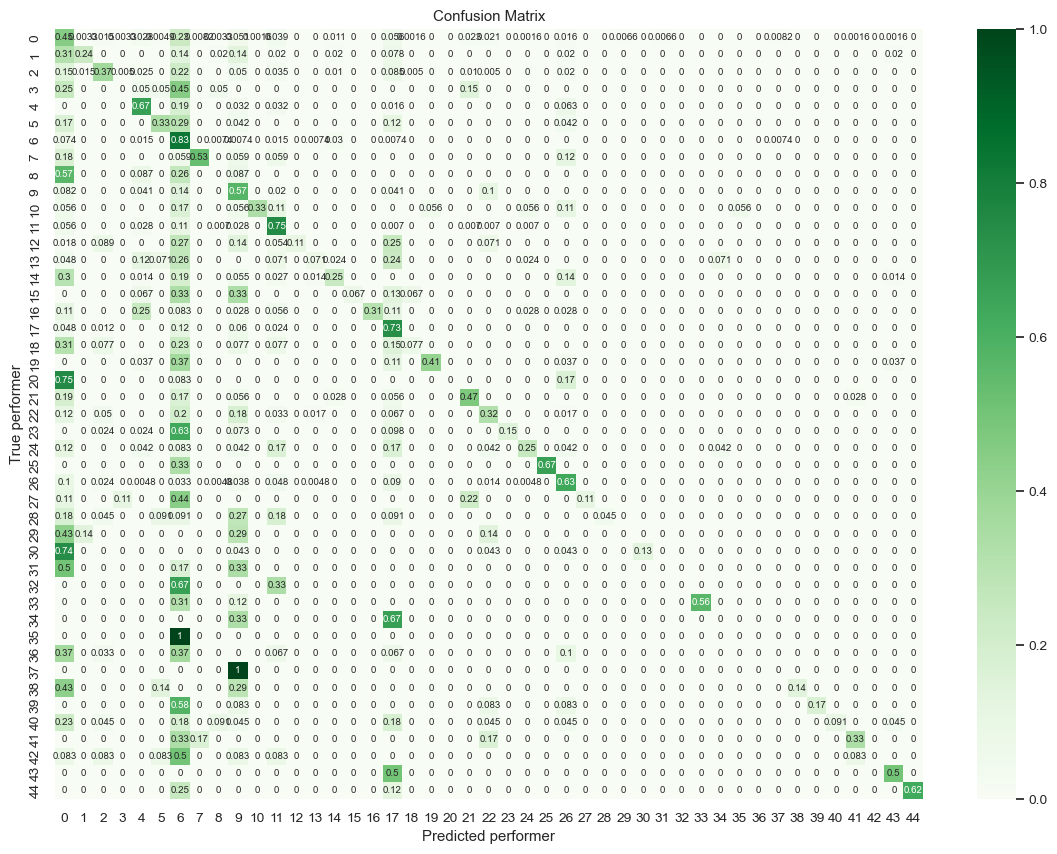

In [10]:
# confusion matrix

#y_pred_test = rfc.predict(X_test)
y_pred_test = rfc_cv.predict(X_test)

matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14,10))
sns.set(font_scale=0.9)
sns.heatmap(matrix, annot=True, annot_kws={'size':7}, cmap=plt.cm.Greens)#, linewidths=0.2)
plt.xlabel('Predicted performer')
plt.ylabel('True performer')
plt.title('Confusion Matrix')
plt.show()

In [11]:
# Precision, recall, F1-score 

#y_pred_test = rfc.predict(X_test)
y_pred_test = rfc_cv.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.55      0.45      0.50       609
           1       0.67      0.24      0.35        51
           2       0.72      0.37      0.49       199
           3       0.00      0.00      0.00        20
           4       0.44      0.67      0.53        63
           5       0.42      0.33      0.37        24
           6       0.21      0.83      0.33       135
           7       0.60      0.53      0.56        17
           8       0.00      0.00      0.00        23
           9       0.18      0.57      0.27        49
          10       0.86      0.33      0.48        18
          11       0.58      0.75      0.65       142
          12       1.00      0.11      0.19        56
          13       0.43      0.07      0.12        42
          15       0.53      0.25      0.34        73
          16       1.00      0.07      0.12        15
          18       1.00      0.31      0.47        36
          19       0.30    

d:\Users\jonph\miniconda3\envs\ai-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Users\jonph\miniconda3\envs\ai-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Users\jonph\miniconda3\envs\ai-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Expression Style Profile (ESP) input - Random Forest
https://github.com/anusfoil/Style-Profile

In [5]:
ATEPP_ESP = pd.read_csv('extracted_features/atepp_attributes.csv')
print(len(ATEPP_ESP), 'performances in full dataset')
artists = ATEPP_ESP['artist'].to_numpy()
pianists, counts = np.unique(artists, return_counts=True)
composers = ATEPP_ESP['composer'].to_numpy()
composers, counts = np.unique(composers, return_counts=True)
print(len(pianists), 'pianists in full dataset') 
print(len(composers), 'composers in full dataset')

3550 performances in full dataset
49 pianists in full dataset
14 composers in full dataset


In [50]:
# performers that appear >= 15 times
# sp_dynamics_agreement and sp_kor_staccato lots NaNs so dropped
# dropping sp_dynamics_consistency_std lowered acc

#print(ATEPP_ESP.isnull().sum())
ATEPP_ESP_filtered = ATEPP_ESP.drop(['sp_dynamics_agreement', 'sp_kor_staccato'], axis=1)
ATEPP_ESP_filtered = ATEPP_ESP_filtered.dropna(axis=0) # drop rest of NaNs
ATEPP_ESP_filtered = ATEPP_ESP_filtered.groupby('artist_id').filter(lambda x: len(x) >= 15)

# checking unbalancedness of dataset

#artist_ids = ATEPP_ESP_filtered['artist_id'].to_numpy()
artist_ids = ATEPP_ESP_filtered['artist'].to_numpy()
pianist_ids, counts = np.unique(artist_ids, return_counts=True)
for pianist, count in zip(pianist_ids, counts):
    print(f"{pianist}: {count}")

print('')
print(len(ATEPP_ESP_filtered), 'performances')
print(len(ATEPP_ESP_filtered['artist_id'].unique()), 'pianists in filtered dataset')

Alfred Brendel: 148
Alfred Cortot: 51
Alicia de Larrocha: 41
András Schiff: 31
Artur Schnabel: 52
Arturo Benedetti Michelangeli: 18
Claudio Arrau: 211
Daniel Barenboim: 138
Dinu Lipatti: 56
Edwin Fischer: 16
Emil Gilels: 79
Evgeny Kissin: 24
Friedrich Gulda: 118
Glenn Gould: 45
Grigory Sokolov: 32
Lang Lang: 24
Martha Argerich: 65
Maurizio Pollini: 73
Mikhail Pletnev: 19
Mitsuko Uchida: 43
Murray Perahia: 52
Nikolai Lugansky: 32
Robert Casadesus: 32
Samson François: 133
Sviatoslav Richter: 205
Valentina Lisitsa: 18
Vladimir Ashkenazy: 227
Vladimir Horowitz: 155
Walter Gieseking: 89
Wilhelm Kempff: 110
Zoltán Kocsis: 29

2366 performances
31 pianists in filtered dataset


In [51]:
# obtain predictor variable x, and labels y

def getXy(df):
  y = df['artist'].to_numpy()
  #X = df.iloc[:,10:].to_numpy() # for original file
  X = df.iloc[:,11:].to_numpy() 

  print('X shape:', X.shape)
  print('y shape:', y.shape)

  return X, y

In [52]:
# get X, y for 2366 performances

X, y = getXy(ATEPP_ESP_filtered)

X shape: (2366, 12)
y shape: (2366,)


In [53]:
# Split into train and test datasets

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Random forest

rfc = RandomForestClassifier(n_estimators=200, class_weight='balanced')
rfc.fit(X_train, y_train)

print('Training dataset accuracy: {:.2f}'.format(rfc.score(X_train, y_train)))
print('Test dataset accuracy: {:.2f}.'.format(rfc.score(X_test, y_test)))

In [54]:
# RFC with grid search CV

parameters = {'n_estimators': [100, 200, 400],'max_features':[1,2,3,4,7,9,10,12]}

rfc = RandomForestClassifier(class_weight='balanced')
rfc_cv = GridSearchCV(rfc, parameters, cv=5)
rfc_cv.fit(X_train, y_train)

print('Best hyperparameters: {}.'.format(rfc_cv.best_estimator_))
print('Training dataset accuracy: {:.2f}'.format(rfc_cv.score(X_train, y_train)))
print('Test dataset accuracy: {:.2f}.'.format(rfc_cv.score(X_test, y_test)))

Best hyperparameters: RandomForestClassifier(class_weight='balanced', max_features=2,
                       n_estimators=200).
Training dataset accuracy: 1.00
Test dataset accuracy: 0.48.


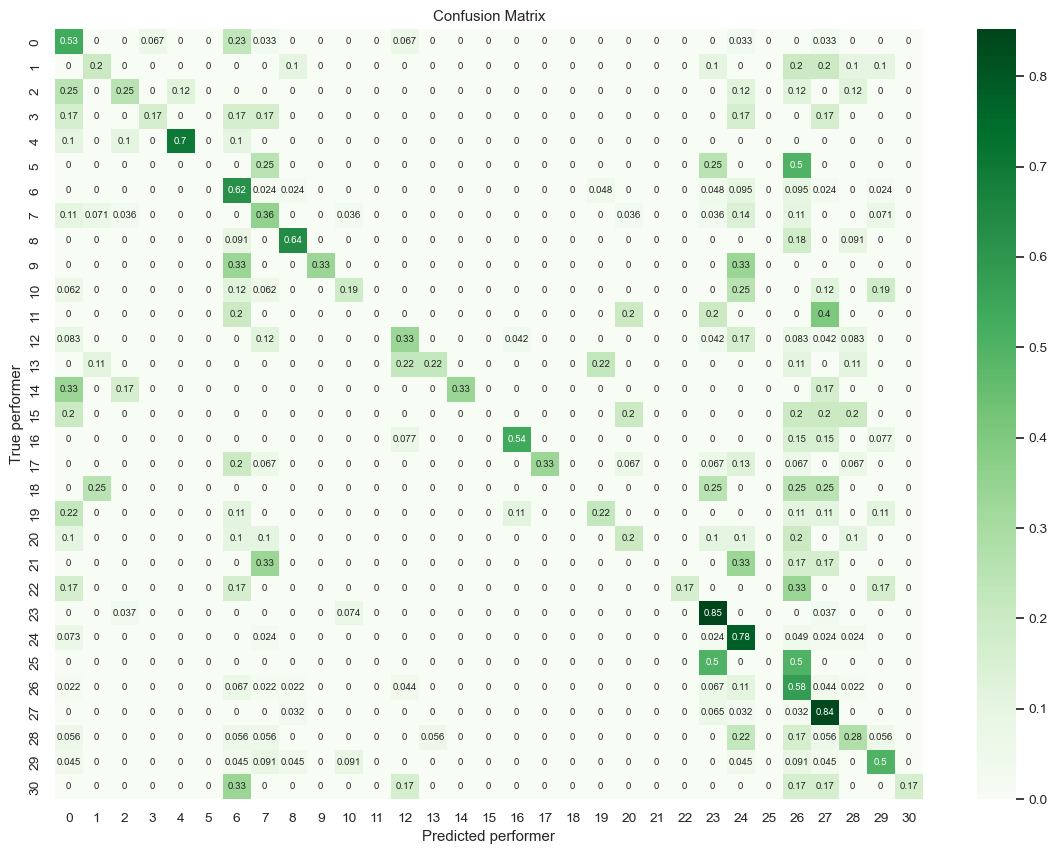

In [55]:
# confusion matrix

#y_pred_test = rfc.predict(X_test)
y_pred_test = rfc_cv.predict(X_test)

matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14,10))
sns.set(font_scale=0.9)
sns.heatmap(matrix, annot=True, annot_kws={'size':7}, cmap=plt.cm.Greens)
plt.xlabel('Predicted performer')
plt.ylabel('True performer')
plt.title('Confusion Matrix')
plt.show()

In [56]:
# Precision, recall, F1-score 

#y_pred_test = rfc.predict(X_test)
y_pred_test = rfc_cv.predict(X_test)
print(classification_report(y_test, y_pred_test))

                               precision    recall  f1-score   support

               Alfred Brendel       0.41      0.53      0.46        30
                Alfred Cortot       0.33      0.20      0.25        10
           Alicia de Larrocha       0.33      0.25      0.29         8
                András Schiff       0.33      0.17      0.22         6
               Artur Schnabel       0.88      0.70      0.78        10
Arturo Benedetti Michelangeli       0.00      0.00      0.00         4
                Claudio Arrau       0.49      0.62      0.55        42
             Daniel Barenboim       0.37      0.36      0.36        28
                 Dinu Lipatti       0.58      0.64      0.61        11
                Edwin Fischer       1.00      0.33      0.50         3
                  Emil Gilels       0.38      0.19      0.25        16
                Evgeny Kissin       0.00      0.00      0.00         5
              Friedrich Gulda       0.50      0.33      0.40        24
     

d:\Users\jonph\miniconda3\envs\ai-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Users\jonph\miniconda3\envs\ai-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Users\jonph\miniconda3\envs\ai-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Combined MFCCs and ESP inputs - Random Forest

In [15]:
# Use all ESP as before, and add MFCCs for the same performances

def getXy(df):
  X = []
  y = df['artist_id']

  x_ESP = df.iloc[:,11:].to_numpy() 

  for _, row in tqdm(df.iterrows()):
    file = row['piece_path']
    x, sr = librosa.load(file)
    xi = np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc=20).T, axis=0)
    X.append(xi)

  X = np.concatenate((X, x_ESP), axis=1)
  X = np.array(X)
  y = np.array(y)

  print('\nX shape:', X.shape)
  print('y shape:', y.shape)

  return X, y

In [16]:
# Saved X, y to numpy files
# X, y = getXy(ATEPP_ESP_filtered)
# np.save('./extracted_features/ATEPP_ESP_filtered-MFCCs&ESP-X.npy', X)
# np.save('./extracted_features/ATEPP_ESP_filtered-MFCCs&ESP-y.npy', y)

2366it [50:10,  1.27s/it]


X shape: (2366, 32)
y shape: (2366,)


In [57]:
# Load X, y 
X = np.load('./extracted_features/ATEPP_ESP_filtered-MFCCs&ESP-X.npy')
y = np.load('./extracted_features/ATEPP_ESP_filtered-MFCCs&ESP-y.npy')

print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (2366, 32)
y shape: (2366,)


In [58]:
# Split into train and test datasets

#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [22]:
# Random forest

rfc = RandomForestClassifier(bootstrap=False, class_weight='balanced', n_estimators=550)
rfc.fit(X_train, y_train)

print('Training dataset accuracy: {:.2f}'.format(rfc.score(X_train, y_train)))
print('Test dataset accuracy: {:.2f}.'.format(rfc.score(X_test, y_test)))

Training dataset accuracy: 1.00
Test dataset accuracy: 0.59.


In [59]:
# RFC with grid search CV

parameters = {'n_estimators': [100, 200, 400, 600],'max_features':[2,3,5,6,9,13,15,22,32]}

rfc = RandomForestClassifier(class_weight='balanced')
rfc_cv = GridSearchCV(rfc, parameters, cv=5)
rfc_cv.fit(X_train, y_train)

print('Best hyperparameters: {}.'.format(rfc_cv.best_estimator_))
print('Training dataset accuracy: {:.2f}'.format(rfc_cv.score(X_train, y_train)))
print('Test dataset accuracy: {:.2f}.'.format(rfc_cv.score(X_test, y_test)))

Best hyperparameters: RandomForestClassifier(class_weight='balanced', max_features=32,
                       n_estimators=600).
Training dataset accuracy: 1.00
Test dataset accuracy: 0.58.


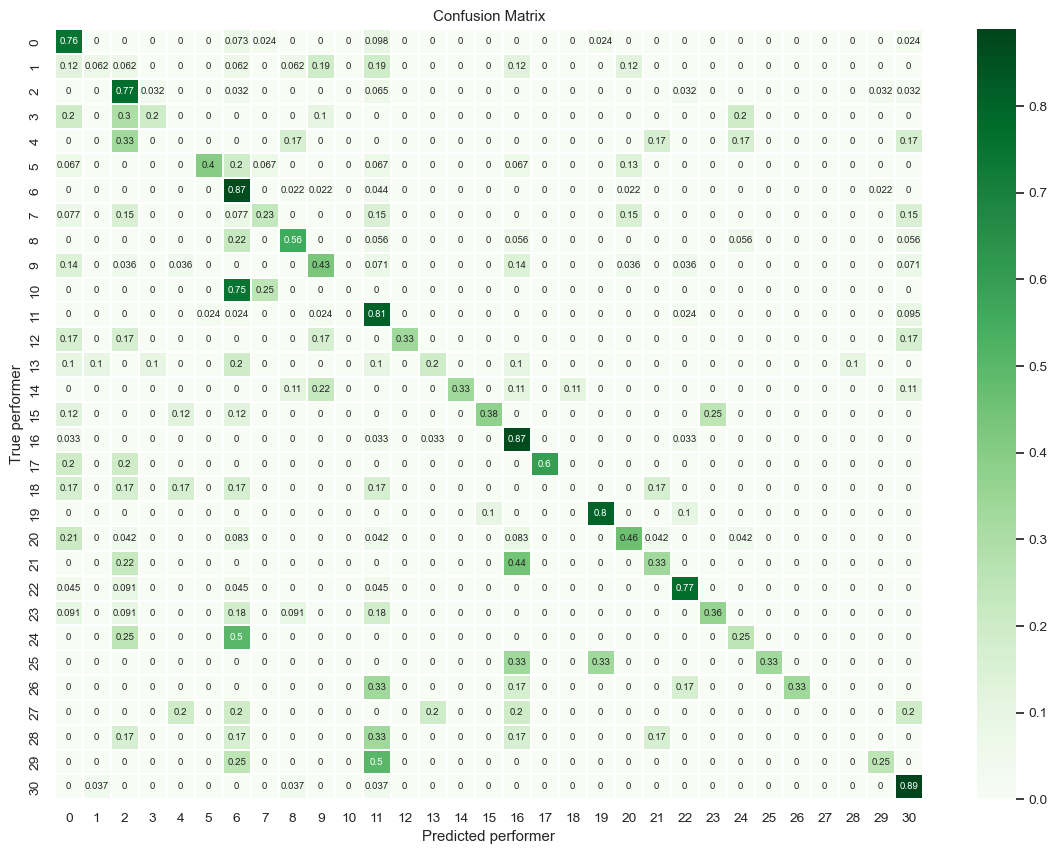

In [60]:
# confusion matrix

#y_pred_test = rfc.predict(X_test)
y_pred_test = rfc_cv.predict(X_test)

matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14,10))
sns.set(font_scale=0.9)
sns.heatmap(matrix, annot=True, annot_kws={'size':7}, cmap=plt.cm.Greens, linewidths=0.2)
plt.xlabel('Predicted performer')
plt.ylabel('True performer')
plt.title('Confusion Matrix')
plt.show()

In [61]:
# Precision, recall, F1-score 

#y_pred_test = rfc.predict(X_test)
y_pred_test = rfc_cv.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.57      0.76      0.65        41
         1.0       0.33      0.06      0.11        16
         2.0       0.55      0.77      0.64        31
         3.0       0.50      0.20      0.29        10
         4.0       0.00      0.00      0.00         6
         5.0       0.86      0.40      0.55        15
         6.0       0.56      0.87      0.68        45
         7.0       0.50      0.23      0.32        13
         8.0       0.62      0.56      0.59        18
         9.0       0.57      0.43      0.49        28
        10.0       0.00      0.00      0.00         4
        11.0       0.52      0.81      0.64        42
        12.0       1.00      0.33      0.50         6
        13.0       0.50      0.20      0.29        10
        15.0       1.00      0.33      0.50         9
        18.0       0.75      0.38      0.50         8
        19.0       0.57      0.87      0.68        30
        20.0       1.00    

d:\Users\jonph\miniconda3\envs\ai-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Users\jonph\miniconda3\envs\ai-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Users\jonph\miniconda3\envs\ai-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Neural Networks

In [6]:
import matplotlib.pyplot as plt
import lightning.pytorch as pl
from lightning.pytorch import Trainer
import torch
import torchmetrics
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

# MAKE SURE TO CREATE THE CORRECT CLASS WEIGHTS (either regular or style vs environment)
# and choose correct metadata_dir

In [ ]:
# reload ATEPPAudioDataset.py
import importlib
import ATEPPAudioDataset
importlib.reload(ATEPPAudioDataset)

In [8]:
# Lightning data module

from ATEPPAudioDataset import ATEPPAudioDataset
from torch.utils import data

class ATEPPAudioLitData(pl.LightningDataModule):
  def __init__(self, metadata_dir='./metadata', # ./metadata or ./metadata/style_vs_environment if testing style vs environment
               sample_rate=16000, 
               num_samples=15*16000, # 59049 for 3.69s
               num_chunks=1,
               is_augmentation=False, 
               batch_size=16,
               num_workers=6,
               pin_memory=True):
    super().__init__()

    # store data-related parameters
    self.metadata_dir = metadata_dir
    self.sample_rate = sample_rate
    self.num_samples = num_samples
    self.num_chunks = num_chunks
    self.is_augmentation = is_augmentation
    self.batch_size = batch_size
    self.num_workers = num_workers
    self.pin_memory=pin_memory

  # def prepare_data(self):
  #   pass # using 'ATEPPAudioDataset' regular custom PyTorch dataset class instead

  def setup(self, stage=None):  
    # setup is run first to get train, val, test sets for the data loaders (below)

    self.train_dataset = ATEPPAudioDataset(self.metadata_dir, self.sample_rate, self.num_samples, 'train', self.num_chunks, self.is_augmentation)
    self.val_dataset = ATEPPAudioDataset(self.metadata_dir, self.sample_rate, self.num_samples, 'val', self.num_chunks, self.is_augmentation)
    self.test_dataset = ATEPPAudioDataset(self.metadata_dir, self.sample_rate, self.num_samples, 'test', self.num_chunks, self.is_augmentation)
  
  def train_dataloader(self):
    return get_dataloader('train', self.train_dataset, self.batch_size, self.num_workers, self.pin_memory, self.num_chunks)
  
  def val_dataloader(self):
    return get_dataloader('val', self.val_dataset, self.batch_size, self.num_workers, self.pin_memory, self.num_chunks)

  def test_dataloader(self):
    return get_dataloader('test', self.test_dataset, self.batch_size, self.num_workers, self.pin_memory, self.num_chunks)
  
  def predict_dataloader(self): # same as test but allows different functionality
    return get_dataloader('predict', self.test_dataset, self.batch_size, self.num_workers, self.pin_memory, self.num_chunks)


def get_dataloader(split, dataset, batch_size, num_workers, pin_memory, num_chunks):
  batch_size = batch_size if (split == 'train') else (batch_size // num_chunks)
  is_shuffle = True if (split == 'train') else False
  data_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=is_shuffle, num_workers=num_workers, pin_memory=pin_memory)
  return data_loader

In [9]:
from torch import nn

class LightningWrapper(pl.LightningModule):
  def __init__(self, model: nn.Module,
               learning_rate=1e-3, 
               num_classes=23): 
    super().__init__()

    self.save_hyperparameters(ignore=['model']) 

    self.model = model

    # Loss and metrics
    self.loss_fn = nn.CrossEntropyLoss() #weight=class_weights specified later
    self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
    self.learning_rate = learning_rate
  
  def forward(self, x):
    return self.model(x)
  
  def configure_optimizers(self): 
    return torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=1e-6)
  
  def training_step(self, batch, batch_idx):
    inputs, labels = batch
    logits = self(inputs)
    loss = self.loss_fn(logits, labels)

    train_metrics = {'train/accuracy': self.accuracy(logits.argmax(dim=-1), labels), 'train/loss': loss} 
    self.log_dict(train_metrics, on_epoch=True, prog_bar=True)

    return loss
  
  def validation_step(self, batch, batch_idx):
    inputs, labels = batch
    
    # reshape and aggregate chunk-level predictions
    b, c, t = inputs.size()
    logits = self(inputs.view(-1, t))
    logits = logits.view(b, c, -1).mean(dim=1)
    loss = self.loss_fn(logits, labels)

    val_metrics = {'val/accuracy': self.accuracy(logits.argmax(dim=-1), labels), 'val/loss': loss}
    self.log_dict(val_metrics, on_epoch=True, prog_bar=True)

    return loss
  
  def test_step(self, batch, batch_idx):
    inputs, labels = batch

    # reshape and aggregate chunk-level predictions
    b, c, t = inputs.size() 
    logits = self(inputs.view(-1, t)) 
    logits = logits.view(b, c, -1).mean(dim=1) 
    loss = self.loss_fn(logits, labels)

    # self.accuracy(logits.argmax(dim=-1), labels)
    # self.log("test/accuracy", self.accuracy, on_epoch=True, prog_bar=True)

    return loss

  def predict_step(self, batch, batch_idx):
    inputs, labels = batch

    # reshape and aggregate chunk-level predictions
    b, c, t = inputs.size() 
    logits = self(inputs.view(-1, t)) 
    logits = logits.view(b, c, -1).mean(dim=1) 
    _, pred = torch.max(logits.data, 1)

    return pred, labels

In [10]:
# set precision for faster training 
torch.set_float32_matmul_precision('medium') # high forces FP32, med allows TF32

In [ ]:
#### TRAIN THE MODEL ####

from Models import ShortChunkCNNRes, CNNSA, FCN, Musicnn, HarmonicCNN

inner_model = ShortChunkCNNRes(n_class=23)
model = LightningWrapper(inner_model)
model.loss_fn = nn.CrossEntropyLoss(weight=class_weights)
datamodule = ATEPPAudioLitData(num_samples=59049, num_chunks=16) 

### train the model ###
checkpoint_callback = ModelCheckpoint(monitor='val/accuracy', mode='max', save_top_k=1, save_last=True,
                                      filename='best-model-{epoch:02d}-{val/accuracy:.2f}')
early_stop_callback = EarlyStopping(monitor='val/loss', min_delta=0.00, patience=5, mode='min')

trainer = Trainer(callbacks=[checkpoint_callback, early_stop_callback], max_epochs=140) 
trainer.fit(model, datamodule) 

# if need to specify a checkpoint to continue training:
#trainer.fit(model, ckpt_path='lightning_logs/version_0/checkpoints/last.ckpt', datamodule=datamodule)

In [ ]:
#### TRANSFER LEARNING ####

from Models import ShortChunkCNNRes, CNNSA, FCN, Musicnn, HarmonicCNN

# load the pre-trained model 
inner_model = ShortChunkCNNRes(n_class=50)
inner_model.load_state_dict(torch.load('../pre-trained_models/short_res/jamendo_short_res_best_model.pth'))

# freeze the weights of the pre-trained model
#model.freeze() # freezes the entire model, means have to unfreeze final dense layer
for param in inner_model.parameters():
    param.requires_grad = False

# change the final layer to output 23 classes instead of 50 (not frozen by default)
inner_model.dense2 = nn.Linear(inner_model.dense2.in_features, 23) # for short_res, Musicnn, HarmonicCNN
#inner_model.dense = nn.Linear(inner_model.dense.in_features, 23) # for attention, fcn

model = LightningWrapper(inner_model)
model.loss_fn = nn.CrossEntropyLoss(weight=class_weights) # use class weights from earlier

# train the transfer learning model to fine-tune the weights on the new dataset
checkpoint_callback = ModelCheckpoint(monitor='val/accuracy', mode='max', save_top_k=1, save_last=True,
                                      filename='best-model-{epoch:02d}-{val/accuracy:.2f}')
early_stop_callback = EarlyStopping(monitor='val/loss', min_delta=0.00, patience=5, mode='min')

trainer = Trainer(callbacks=[checkpoint_callback, early_stop_callback], max_epochs=100) 
datamodule = ATEPPAudioLitData(num_samples=59049, num_chunks=16)
trainer.fit(model, datamodule)

In [ ]:
### GET PREDICTIONS ###
# I specified .predict to use the test dataset

# if need to load from specific checkpoint (run above training code first, minus trainer.fit)
predictions = trainer.predict(model, datamodule, ckpt_path='lightning_logs/hcnn_12-chunks_style_vs_env/checkpoints/best-model-epoch=16-val/accuracy=0.40.ckpt')

# predict with the best model
# best_model_path = checkpoint_callback.best_model_path
# predictions = trainer.predict(model, datamodule, ckpt_path=best_model_path)

In [77]:
y_pred = torch.cat([pred for pred, _ in predictions])
y_true = torch.cat([true for _, true in predictions])

print(len(y_true.unique()), 'total labels to predict') # should be 23
print(len(y_pred.unique()), 'total labels predicted') 

23 total labels to predict
23 total labels predicted


Accuracy: 0.2189


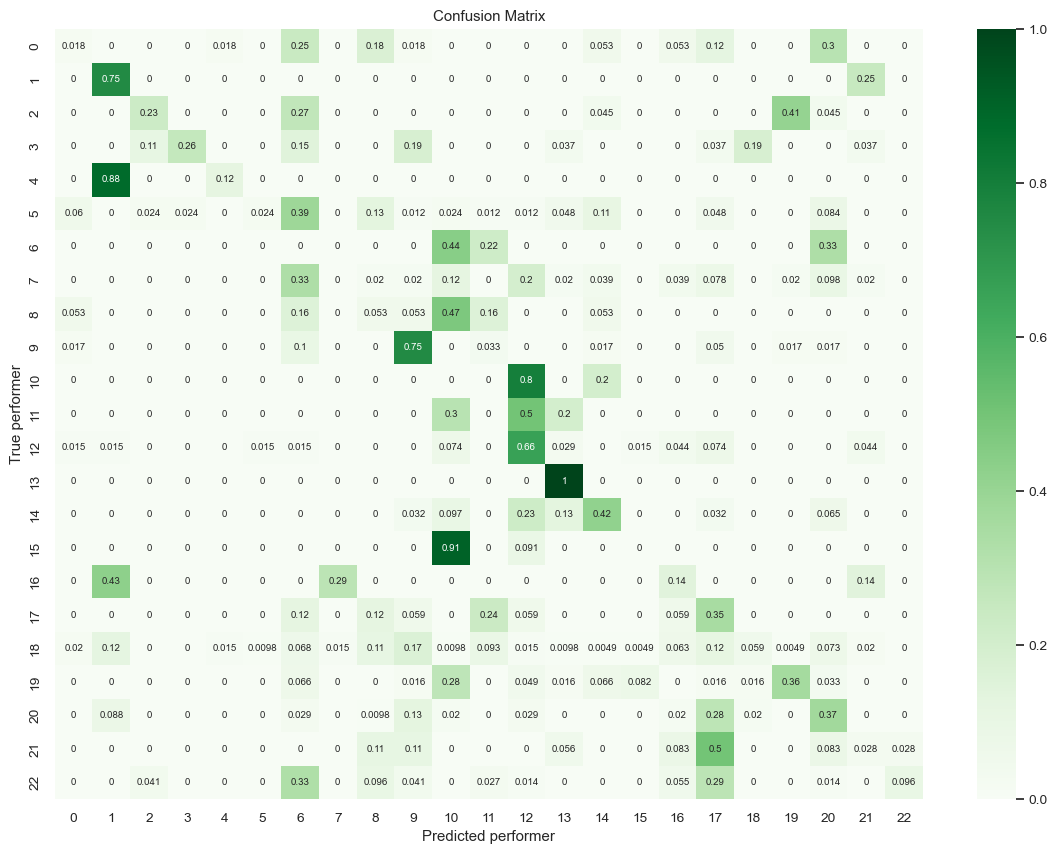

In [78]:
# confusion matrix

accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %.4f' % accuracy)

matrix = confusion_matrix(y_true, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14,10))
sns.set(font_scale=0.9)
sns.heatmap(matrix, annot=True, annot_kws={'size':7}, cmap=plt.cm.Greens)#, linewidths=0.2)
plt.xlabel('Predicted performer')
plt.ylabel('True performer')
plt.title('Confusion Matrix')
plt.show()

In [79]:
# Precision, recall, F1-score 

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.08      0.02      0.03        57
           1       0.05      0.75      0.10         4
           2       0.38      0.23      0.29        22
           3       0.78      0.26      0.39        27
           4       0.33      0.12      0.17        17
           5       0.40      0.02      0.05        83
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        51
           8       0.02      0.05      0.03        19
           9       0.41      0.75      0.53        60
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00        20
          12       0.50      0.66      0.57        68
          13       0.30      1.00      0.46         9
          14       0.36      0.42      0.39        31
          15       0.00      0.00      0.00        22
          16       0.03      0.14      0.05         7
          17       0.05    

## Creating metadata files

In [82]:
### Processing ESP metadata ###
# Adding a piece_path column to atepp_attributes.csv (according to matching youtube_link)

# ATEPP_ESP_YT_links = ATEPP_ESP['youtube_links'].to_numpy()

# for _, row in ATEPP_metadata.iterrows():
#   if row['youtube_link'] in ATEPP_ESP_YT_links:
#     ATEPP_ESP.loc[ATEPP_ESP['youtube_links'] == row['youtube_link'], 'piece_path'] = row['piece_path']

# move PIECE_PATH column to before features
# cols = list(ATEPP_ESP.columns)
# cols = [cols[-1]] + cols[:-1] 
# ATEPP_ESP = ATEPP_ESP[cols]

In [85]:
# create csv of atepp_attributes
#ATEPP_ESP.to_csv('extracted_features/atepp_attributes.csv', index=False)

In [10]:
### creating ATEPP-audio-full-metadata.csv
# compiling metadata

files = glob.glob('./**/*.mp3', recursive=True)

def createMetadata(files):
  X = []

  for file in tqdm(files):
    mp3_dir = os.path.dirname(file)
    csv_path = os.path.join(mp3_dir, 'tracks.csv')
    df = pd.read_csv(csv_path)

    for _, row in df.iterrows():
      audio_path = row['audio_path']
      full_audio_path = os.path.join(mp3_dir, audio_path)
      
      if full_audio_path in file: # only extracting metadata for existing audio files
        artist_id = int(row['artist_id'])
        artist = row['artist']
        track = row['track']
        composer = row['composer']
        YT_link = row['youtube_links']
        album = row['album']
        album_date = row['album_date(yyyy-mm-dd)']
        xi = np.append(artist, [artist_id, track, composer, file, YT_link, album, album_date])
        X.append(xi)
  
  X = np.array(X)
  headers = ["artist", "artist_id", "track", "composer", "piece_path", "youtube_link", "album", "album_date(yyyy-mm-dd)"]
  df = pd.DataFrame(data=X, columns=headers)

  return df

In [11]:
df = createMetadata(files)

100%|██████████| 11762/11762 [01:01<00:00, 190.77it/s]


In [12]:
# create the metadata csv
#df.to_csv("./metadata/ATEPP-audio-full-metadata.csv", index=False)

In [ ]:
# example metadata entry

df = pd.read_csv('./Frédéric_Chopin/12_Études,_Op._10/No._1_in_C_Major_Waterfall/tracks.csv')
df = df.astype({'artist_id': int})

# obtain from glob
piece_path = './Frédéric_Chopin/12_Études,_Op._10/No._1_in_C_Major_Waterfall/0.mp3'

#audio_path = './Frédéric_Chopin/12_Études,_Op._10/No._1_in_C_Major_Waterfall'
#audio_file = df['audio_path'][0]
#composer = df['composer'][0]
#piece_path = audio_path + '/' + audio_file

#print(piece_path)
os.path.exists(piece_path)

['0.mp3',
 '1.mp3',
 '2.mp3',
 '3.mp3',
 '4.mp3',
 '5.mp3',
 '6.mp3',
 '7.mp3',
 '8.mp3',
 '9.mp3',
 '10.mp3',
 '11.mp3']